# Analysis for the the one with curriculum learning

In [1]:
import tbparse
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# For the training

In [2]:
from tbparse import SummaryReader
Gen_ARL_train = r"../../TrainerConfig/results/Curr42d/Generator/"
Solver_ARL_train = r"../../TrainerConfig/results/Curr42d/Solver/"
reader_gen = SummaryReader(Gen_ARL_train)
reader_solver = SummaryReader(Solver_ARL_train)
df_solver = reader_solver.scalars
df_gen = reader_gen.scalars
pd.unique(df_gen["tag"])
# df_gen.head()
# df_gen

array(['Environment/Cumulative Reward', 'Environment/Episode Length',
       'Environment/Lesson Number/aux_input',
       'Environment/Lesson Number/n_obstacles',
       'Losses/Curiosity Forward Loss', 'Losses/Curiosity Inverse Loss',
       'Losses/Policy Loss', 'Losses/Value Loss', 'Policy/Beta',
       'Policy/Curiosity Reward', 'Policy/Curiosity Value Estimate',
       'Policy/Entropy', 'Policy/Epsilon', 'Policy/Extrinsic Reward',
       'Policy/Extrinsic Value Estimate', 'Policy/Learning Rate', 'Score',
       'Y_difference', 'distance', 'height', 'theta'], dtype=object)

In [3]:
df_gen

,step,tag,value
0,1000,Environment/Cumulative Reward,1.182363
1,2000,Environment/Cumulative Reward,1.892153
2,3000,Environment/Cumulative Reward,3.627184
3,4000,Environment/Cumulative Reward,4.152931
4,5000,Environment/Cumulative Reward,5.583900
...,...,...,...
5742,366000,theta,-0.038249
5743,367000,theta,0.992048
5744,368000,theta,1.707731
5745,369000,theta,-0.894614


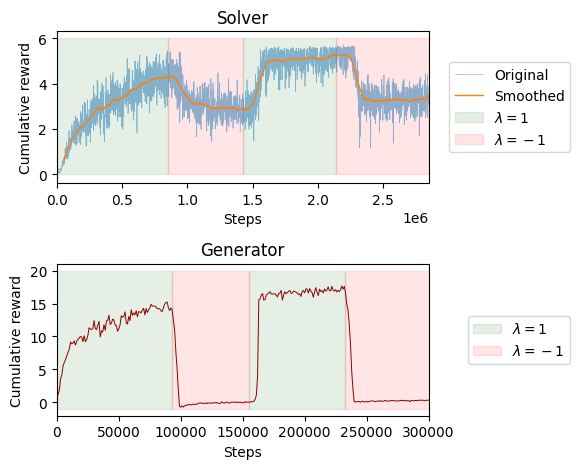

In [4]:
auxs = [0, .3, .5, .75, 1]
solver_cum_pd = df_solver.loc[df_solver["tag"]=="Environment/Cumulative Reward", ["step", "value"]]
ax1 = plt.subplot(2,1,1)

maxstep = 2.85e6
#  Generator
kwards = {'x':"step", 'y':"value", "kind":"line"}
solver_cum_pd.plot(**kwards, linewidth=.5, ax=ax1, alpha=.5, label="Original")
#  Smoothed version
solver_cum_pd.rolling(100).mean().plot(**kwards, linewidth=1, ax=ax1, label="Smoothed")
ax1.set_xlabel("Steps")
ax1.set_ylabel("Cumulative reward")
ax1.set_xlim(0, maxstep)
ax1.set_title("Solver")
fill_args = {'alpha':0.1}
ymax = 6
# Regions
ax1.fill_betweenx([0,ymax],auxs[0]*maxstep,auxs[1]*maxstep, color='darkgreen', **fill_args,
                  label=r"$\lambda=1$")
ax1.fill_betweenx([0,ymax],auxs[1]*maxstep,auxs[2]*maxstep, color='red', **fill_args,
                  label=r"$\lambda=-1$")
ax1.fill_betweenx([0,ymax],auxs[2]*maxstep,auxs[3]*maxstep, color='darkgreen', **fill_args)
ax1.fill_betweenx([0,ymax],auxs[3]*maxstep,auxs[4]*maxstep, color='red', **fill_args)
ax1.legend(loc='center right',bbox_to_anchor=(1.4,.5))

# Solver
maxstep = 3.1e5
ymax=20
ymin=-1
# Solver
ax2 = plt.subplot(2,1,2)
gen_cum_pd = df_gen.loc[df_gen["tag"]=="Environment/Cumulative Reward", ["step", "value"]]
gen_cum_pd.plot(**kwards, ax=ax2, color='darkred', linewidth=.7, label="")
ax2.set_xlabel("Steps")
ax2.set_ylabel("Cumulative reward")
ax2.set_xlim(0, 3e5)
# ax2.legend("", frameon=False)
ax2.set_title("Generator")
# Regions
ax2.fill_betweenx([ymin,ymax],auxs[0]*maxstep,auxs[1]*maxstep, color='darkgreen', **fill_args,
                  label=r"$\lambda=1$")
ax2.fill_betweenx([ymin,ymax],auxs[1]*maxstep,auxs[2]*maxstep, color='red', **fill_args,
                  label=r"$\lambda=-1$")
ax2.fill_betweenx([ymin,ymax],auxs[2]*maxstep,auxs[3]*maxstep, color='darkgreen', **fill_args)
ax2.fill_betweenx([ymin,ymax],auxs[3]*maxstep,auxs[4]*maxstep, color='red', **fill_args)
ax2.legend(loc='center right',bbox_to_anchor=(1.4,.5))
plt.tight_layout()
plt.savefig("images/Cumm_reward_Curr42d.pdf")

# For test

In [27]:
from tbparse import SummaryReader

In [48]:
# Get the scores datas from tensorboard events
# Needs the tbparse module
def get_score(path, aux_input, step_start=100000):
    reader = SummaryReader(path)
    dfScore = reader.scalars
    Score = dfScore.loc[dfScore["tag"]=='Score',['step', 'value']]
    Score.rename(columns = {'value':'Score'}, inplace=True)
    Score["aux_input"] = aux_input
    Score = Score.loc[Score['step'] > step_start,:]
    return Score

In [160]:
ARL  = dict()
PCG  = dict()
PCG_Const = dict()

for aux in [1, 0.5, 0, -0.5, -1]:
    path_ARL = f"../../TrainerConfig/results/InferCurr42d_{aux}/Solver/"
    ARL[aux] = get_score(path_ARL, aux)
    
    path_PCG = f"../../TrainerConfig/results/InferPCG_2_aux_{aux}/Solver/"
    PCG[aux] = get_score(path_PCG, aux)
    
    path_constPCG = f"../../TrainerConfig/results/InferPCG_Const_1_aux_{aux}/Solver/"
    PCG_Const[aux] = get_score(path_constPCG, aux)

### Box plot of the scores for ARLPCG

Text(0.5, 1.0, '')

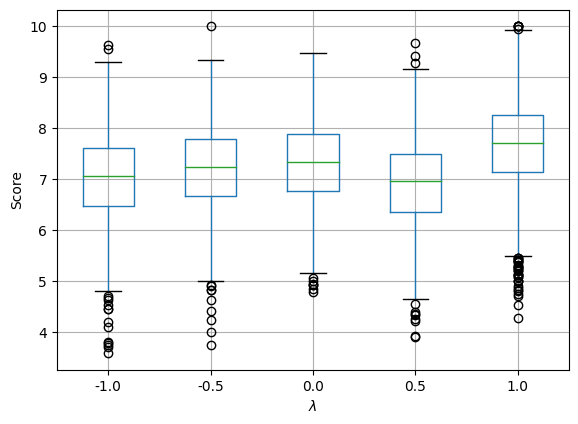

In [113]:
ARLs = pd.concat([ARL[d] for d in ARL]) # Combine the DataFrames
grouped = ARLs.groupby('aux_input')
fig = plt.figure()
ax = fig.gca()
ax.grid()
# bp = grouped.boxplot(column=["Score"], subplots=False, ax=ax)
ARLs.loc[:,["Score", "aux_input"]].boxplot(by="aux_input", ax=ax)
ax.set_xlabel(r"$\lambda$")
ax.set_ylabel("Score")
plt.suptitle("")
plt.title("")

In [154]:
def boxplots(df_dict, suptitle="", title="", ax=None, **kwargs):
    df_dicts = pd.concat([df_dict[d] for d in df_dict]) # Combine the DataFrames
    grouped = df_dicts.groupby('aux_input')
    
    # new figure
    if(ax == None):
        fig = plt.figure()
        ax = fig.gca()
        ax.grid()
    
    # box plot by aux_input
    df_dicts.loc[:,["Score", "aux_input"]].boxplot(by="aux_input", ax=ax, **kwargs)
    ax.set_xlabel(r"$\lambda$")
    ax.set_ylabel("Score")
#     ax.suptitle.set_text(suptitle)
    ax.title.set_text(title)

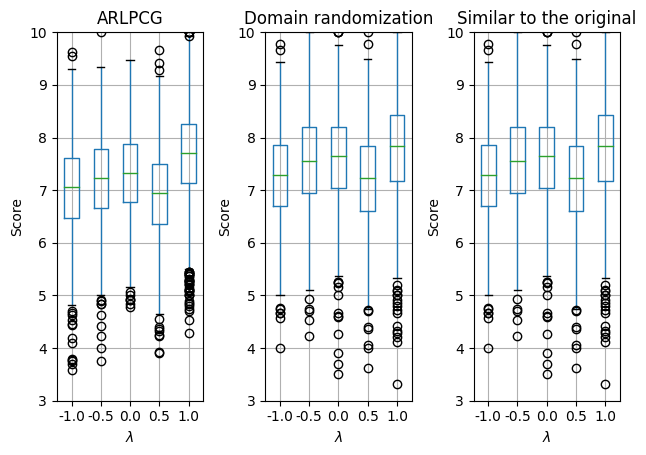

In [161]:
n = 3
fig = plt.figure()
axs = []
[axs.append(plt.subplot(1,n,i)) for i in range(1,n+1)]
# axs.append(plt.subplot(1,3,1))
# axs.append(plt.subplot(1,3,2))
# axs.append(plt.subplot(1,3,3))

for ax in axs:
    ax.set_ylim(3,10)

boxplots(ARL, ax=axs[0], title="ARLPCG")
boxplots(PCG, ax=axs[1], title="Domain randomization")
boxplots(PCG, ax=axs[2], title="Similar to the original")
plt.suptitle("")
plt.tight_layout()

In [ ]:
pd.Series.

In [170]:
PCG_Const[1].mean()

TypeError: cannot convert the series to <class 'float'>

In [164]:
PCG[1].mean()

step         695500.000000
Score             7.846154
aux_input         1.000000
dtype: float64

In [167]:
ARL[1].mean()

step         1.555500e+06
Score        7.671879e+00
aux_input    1.000000e+00
dtype: float64

In [204]:
def means(df_list, tag="Score"):
    value = []
    for d in df_list:
        value.append(d[tag].mean())
    return np.array(value)
    
def medians(df_list, tag="Score"):
    value = []
    for d in df_list:
        value.append(d[tag].median())
    return np.array(value)

def std(df_list, tag="Score"):
    value = []
    for d in df_list:
        value.append(d[tag].std())
    return np.array(value)

def ratio(df, aux, average_method = "mean"):
    if(average_method == "mean"):
        return df[aux]["Score"].mean() / 10
    elif(average_method == "median"):
        return df[aux]["Score"].median() / 10
    else:
        return df[aux]["Score"].mean() / 10
    
def ratioWithStd(df, aux, average_method = "mean"):
    std = df[aux]["Score"].std() / 10
    if(average_method == "mean"):
        av = df[aux]["Score"].mean() / 10
        return f"{av:.3f}$\pm${std:.3f}"
    elif(average_method == "median"):
        av = df[aux]["Score"].median() / 10
        return f"{av:.3f}$\pm${std:.3f}"

# Solving ratio without error

In [197]:
aux_list = [-1, -.5, 0, .5, 1]
models = ["ARLPCG", "PCG", "Const PCG"]
descr = dict()

# Create a table of the solving ratio
descr[models[0]] = {aux:ratio(ARLs, aux) for aux in aux_list} #ARLPCG
descr[models[1]] = {aux:ratio(PCGs, aux) for aux in aux_list} #PCG
descr[models[2]] = {aux: ratio(PCG_Const, aux) for aux in aux_list} #Const PCG

In [198]:
pd.DataFrame(descr)

,ARLPCG,PCG,Const PCG
-1.0,0.701536,0.726023,0.650781
-0.5,0.719238,0.753503,0.667705
0.0,0.730316,0.758374,0.693358
0.5,0.691243,0.719080,0.667566
1.0,0.767188,0.777189,0.729087


In [201]:
descr1 = dict()

# Create a table of the solving ratio
descr1[models[0]] = {aux:ratio(ARLs, aux, average_method='median') for aux in aux_list} #ARLPCG
descr1[models[1]] = {aux:ratio(PCGs, aux, average_method='median') for aux in aux_list} #PCG
descr1[models[2]] = {aux: ratio(PCG_Const, aux,  average_method='median') for aux in aux_list} #Const PCG

pd.DataFrame(descr1)

,ARLPCG,PCG,Const PCG
-1.0,0.705556,0.728175,0.653137
-0.5,0.723529,0.755556,0.666667
0.0,0.733333,0.764286,0.700000
0.5,0.695346,0.723077,0.670588
1.0,0.771429,0.784615,0.733333


# Solving ratio with errors

In [213]:
aux_list = [-1, -.5, 0, .5, 1]
models = ["ARLPCG", "PCG", "Const PCG"]
descrE = dict()

# Create a table of the solving ratio
descrE[models[0]] = {aux:ratioWithStd(ARLs, aux) for aux in aux_list} #ARLPCG
descrE[models[1]] = {aux:ratioWithStd(PCGs, aux) for aux in aux_list} #PCG
descrE[models[2]] = {aux: ratioWithStd(PCG_Const, aux) for aux in aux_list} #Const PCG
descrE = pd.DataFrame(descrE)

# Rename the axis
descrE.rename_axis("$\lambda$", axis=1)

In [215]:
print(descrE.to_latex())

\begin{tabular}{llll}
\toprule
 & ARLPCG & PCG & Const PCG \\
\midrule
-1.000000 & 0.702$\pm$0.087 & 0.726$\pm$0.087 & 0.651$\pm$0.089 \\
-0.500000 & 0.719$\pm$0.082 & 0.754$\pm$0.093 & 0.668$\pm$0.094 \\
0.000000 & 0.730$\pm$0.084 & 0.758$\pm$0.091 & 0.693$\pm$0.090 \\
0.500000 & 0.691$\pm$0.084 & 0.719$\pm$0.092 & 0.668$\pm$0.084 \\
1.000000 & 0.767$\pm$0.085 & 0.777$\pm$0.098 & 0.729$\pm$0.088 \\
\bottomrule
\end{tabular}

